# Orientation AuxTel with new spectractor (September 2021): Part 1 guess (x,y) of order 0

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : June 16th 2021
- up date : September 21th  2021
- update : September 24th 2021 : quickLookExp and run locally
- update : September 29th 2021 : for diffusion
- version v3


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from iminuit import Minuit
import iminuit

In [3]:
iminuit.__version__

'2.7.0'

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [5]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [6]:
from distutils.dir_util import copy_tree

# Configuration

In [7]:
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

# Path

In [8]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [9]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [10]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [11]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [12]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [13]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [14]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_v3.0.csv'

In [15]:
df=pd.read_csv(filename_logbook,index_col=0)

In [16]:
pd.set_option('display.max_rows', None)

In [17]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2100.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [18]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [19]:
#idx=76
#idx=96
idx=109

In [20]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits


In [21]:
print(df.iloc[idx])

index                                                        109
date                                     2021-07-08T05:07:18.207
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000350_quick...
num                                                          350
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.089964
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                  742.25
temperature                                                 12.5
humidity                                                     6.0
windspd                  

In [22]:
myhome=os.getenv("HOME")

In [23]:
dir_images=path_images

In [24]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits'

In [25]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [26]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [27]:
FLAG_ORDER0_LOCATION=False

In [28]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

NO Order 0 location from logbook ! 


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [29]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000350_quickLookExp'

In [30]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [31]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [32]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000350_quickLookExp'

# Configuration of the Spectractor running mode

In [33]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [34]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- the image fits format extracted from quickLookExp images at NCSA has not the exact format required by Spectractor.

In [35]:
from shutil import copyfile

In [36]:
copyfile(filename,filename_image)

'holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits'

In [37]:
from astropy.io import fits

In [38]:
hdu = fits.open(filename_image)

In [39]:
hdu.info()

Filename: holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [40]:
# extract header and the image
header=hdu[0].header
image=hdu[0].data

In [41]:
hdu.close()

## Rotate image

- rotate the image according what is expected in Spectractor

In [42]:
rot_image=np.flip(np.flip(image, 1), 0)

### Remove WCS

- may not be necessary

In [43]:
#del header['WCSAXES']
#del header['CTYPE1']
#del header['CTYPE2']
#del header['CUNIT1']
#del header['CUNIT2']
#del header['CRVAL1']
#del header['CRVAL2']
#del header['CRPIX1']
#del header['CRPIX2']

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [44]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [45]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [46]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     123   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [47]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new image file with Spectractor

In [48]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [49]:
parameters.OBS_NAME

'AUXTEL'

In [50]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [51]:
parameters.DISTANCE2CCD

182.0

In [52]:
parameters.LAMBDA_MIN 

300

In [53]:
parameters.LAMBDA_MAX 

1100

In [54]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [55]:
image.filter_label

''

In [56]:
image.header["FILTER"]

'empty_1'

In [57]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

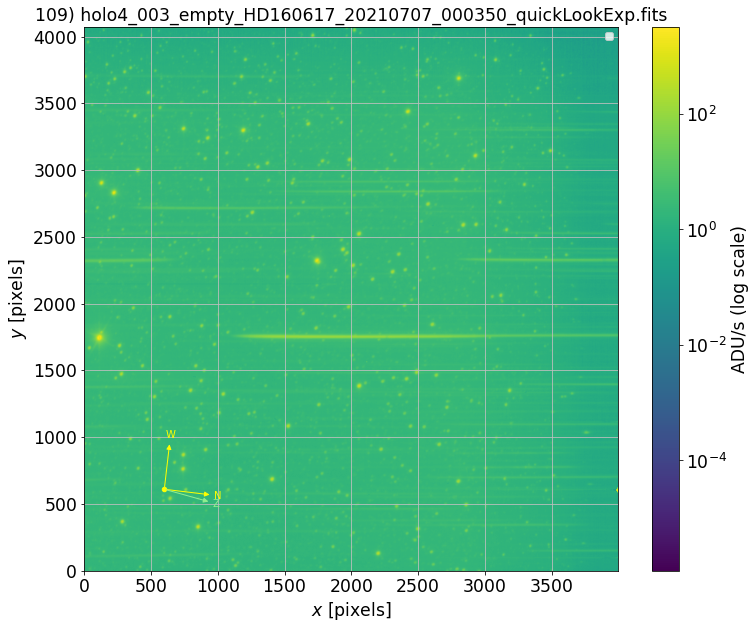

In [58]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

In [59]:
# with filter
guess = [600., 2100.] # filename_image=df['file'][0] , holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][1] , holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][2] , holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][3] , holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][4] , holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][5] , holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][6] , holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][7] , holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][8] , holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][9] , holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
guess = [1300., 700.] # filename_image=df['file'][10] , holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][11] , holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][12] , holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][13] , holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits


# wide scan
guess = [1400., 700.] # filename_image=df['file'][14] , holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
guess = [1400., 800.] # filename_image=df['file'][15] , holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][16] , holo4_003_empty_HD160617_20210707_000250_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][17] , holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][18] , holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][19] , holo4_003_empty_HD160617_20210707_000253_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][20] , holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][21] , holo4_003_empty_HD160617_20210707_000255_quickLookExp.fits

#

# narrrow scan

guess = [500.,2100.] # filename_image=df['file'][76] , 'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'
guess = [500.,2100.] # filename_image=df['file'][77] , 'holo4_003_empty_HD160617_20210707_000318_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][78] , 'holo4_003_empty_HD160617_20210707_000319_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][79] , 'holo4_003_empty_HD160617_20210707_000320_quickLookExp.fits'
guess = [500.,1300.] # filename_image=df['file'][80] , 'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [60]:
filename_image

'holo4_003_empty_HD160617_20210707_000350_quickLookExp.fits'

In [61]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

# Remove temporary input image file (current directory)

In [62]:
#os.remove(filename_image)